<a href="https://colab.research.google.com/github/SALRIGO/pdm04/blob/main/py-tensorflow/pdm04_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##transfer learning 이란?
transfer learning 일명 전이 학습은 이미지넷이 제공하는 거대한 데이터셋을 이용하여 학습한 가중치의 일부를 능력이 유사하거나 새로운 분야의 신경망에 복사한 후 그 상태로 재학습을 수행하는 것을 의미한다.
전이 학습은 학습 데이터가 부족한 프로젝트를 진행하는 경우 매우 큰 도움이 된다. 

- 예를 들면 내가 동양인과 서양인을 구분하는 신경망을 구현하고자 할 때, 여자와 남자를 구분하는 신경망에서 이미지의 특징을 추출하는 부분에 대한 파라미터들을 가져와 나머지를 내 데이터로 학습시켜 완성도를 높이는 것이 전이 학습이다.
- 이 때문에 프로그램이 학습 데이터에 대해 너무 완벽히 학습 해 버리는 overfitting에 유의 하여야 한다


##cifar10에 대한 TL 결과 요약
- 0.의 요구 사항과 같이 trainX = trainX[:5000] 이런식으로 cifar10 데이터의 10%를 가져와 사용 했고
Z-Score을 이용하여 데이터를 정규화 했으며
image augmentation을 사용 하여 학습 이미지에 변화를 주어 모델의 accuracy를 높이고자 하였다.
- 학습 데이터의 량을 10%만 사용 해서 인지 dropout과 가중치를 적용 하였음에도 지속적인 overfitting이 발생 하여 모델의 복잡도를 줄이고자 Dence의 수를 낮춰 조절하고자 시도 하였습니다.

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input   #preprocess_input 전처리를 해주는 함수
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Activation,  BatchNormalization, Dropout, Flatten
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

In [ ]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
# trainX = trainX.astype('float32') / 255
# testX = testX.astype('float32') / 255
#trainy = np_utils.to_categorical(trainy, 10)
#testy = np_utils.to_categorical(testy, 10)
# 0. Data : 10 % cifar10 training data를 이용해서 TL을 수행.
trainX = trainX[:5000] 
trainy = trainy[:5000]
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))   
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(5000, 32, 32, 3), y=(5000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
#ex z-score
mean = np.mean(trainX,axis=(0,1,2,3))
std = np.std(trainX,axis=(0,1,2,3))
trainX = (trainX-mean)/(std+1e-7)
testX = (testX-mean)/(std+1e-7)

In [ ]:
image_generator = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip=True,
    fill_mode = 'nearest',
)

In [ ]:
xtas, ytas = [], []
for i in range(trainX.shape[0]):
    num_aug = 0
    x = trainX[i]
    x = x.reshape((1,) + x.shape)
    for x_aug in image_generator.flow(x, batch_size = 1) :
        if num_aug >= 1:
            break
        xtas.append(x_aug[0])
        num_aug += 1

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [ ]:
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)

In [ ]:
y_train=trainy
y_test=testy
y_train.shape,y_test.shape

((5000, 1), (10000, 1))

In [ ]:
# 1.TL_base: MobileNetV2
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

In [ ]:
# Set TL_base trainable or not.
TL_base.trainable = False  # Use the representative features pretrained by resnet.
#

In [ ]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))   
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) 
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

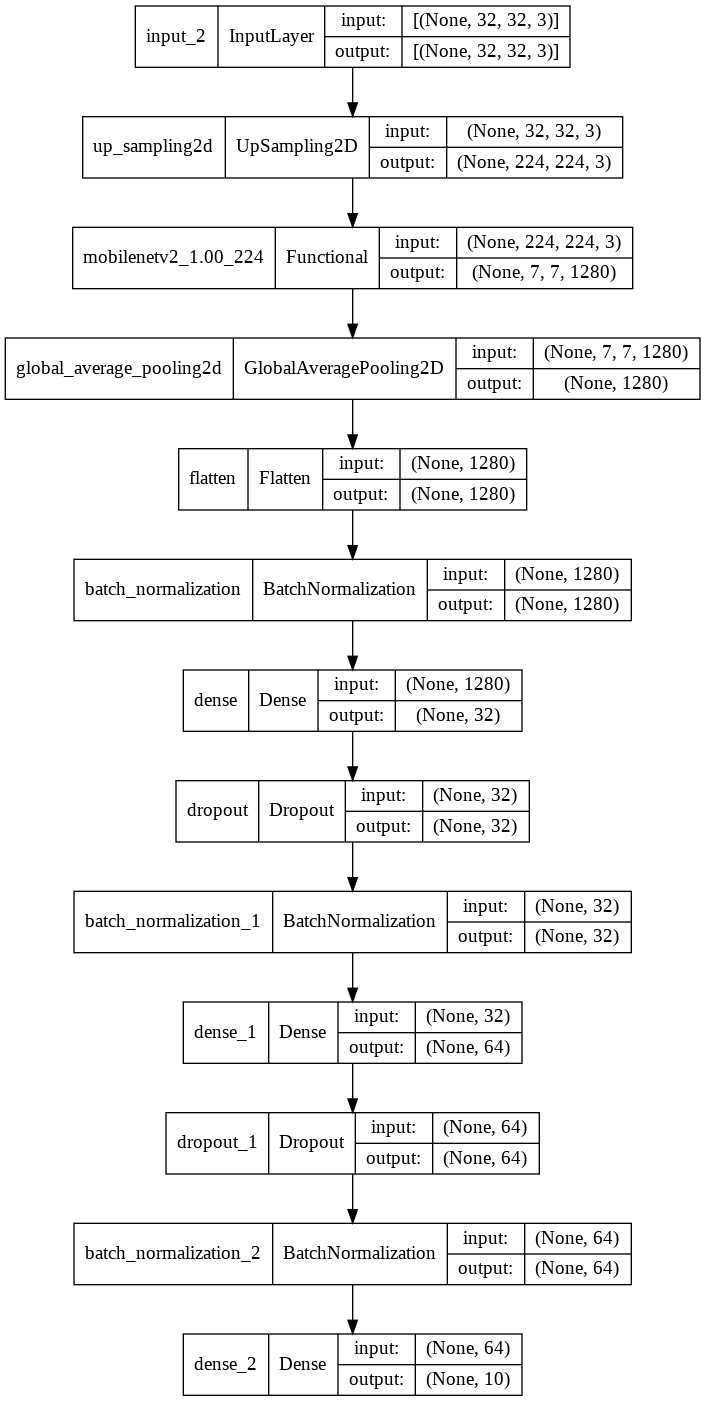

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
#3.Fine Tuning, save the best model
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy']) 

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)   #model이라는 폴터를 만들어줘야함
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5) #바꾸기

In [ ]:
%%time
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=50, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.5925 - accuracy: 0.1676

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 465s 5s/step - loss: 2.5925 - accuracy: 0.1676 - val_loss: 2.4670 - val_accuracy: 0.1069
Epoch 2/100
100/100 [==============================] - 462s 5s/step - loss: 2.2724 - accuracy: 0.2194 - val_loss: 2.5811 - val_accuracy: 0.1000
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 2.0862 - accuracy: 0.2810

In [ ]:
model.evaluate(x_test, y_test, batch_size=50)

## Display training curve

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## BEST model을 이용한 Confusion matrix

In [ ]:
#4. Prediction using the best mode, Confusion matrix
from keras.models import load_model

model_best = load_model('model/cifar10_pct100_mobilenetV2S_SGD_best_weights.027-0.8036.hdf5')
model_best.evaluate(x_test, y_test, batch_size=50)

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions0)

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()